In [30]:
from keras.preprocessing.image import *

from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.image as mpimg
from sklearn.model_selection import train_test_split
import csv
import cv2

import os
from PIL import Image

from glob import glob

%matplotlib inline
from jupyterthemes import jtplot

jtplot.style()

## Read train images

In [4]:
images_per_class = {}

for class_label in tqdm(os.listdir('train')):
    class_folder_path = 'train/%s' % class_label
    images_per_class[class_label] = []
    for image_path in glob(os.path.join(class_folder_path, "*.png")):
        image = img_to_array(load_img(image_path, target_size=(224, 224, 3)))
        images_per_class[class_label].append(image)

100%|██████████| 12/12 [02:50<00:00, 14.19s/it]



### Number of images per class

In [55]:
total = 0
categories = []
for key, value in sorted(images_per_class.items()):
    print("{0} -> {1}".format(key, len(value)))
    total+= len(value)
    categories.append(key)
print('Total Images', total)
print(categories)

Black-grass -> 263
Charlock -> 390
Cleavers -> 287
Common Chickweed -> 611
Common wheat -> 221
Fat Hen -> 475
Loose Silky-bent -> 654
Maize -> 221
Scentless Mayweed -> 516
Shepherds Purse -> 231
Small-flowered Cranesbill -> 496
Sugar beet -> 385
Total Images 4750
['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


### Plot images

In [25]:
def plot_for_class(label):
    nb_rows = 3
    nb_cols = 3
    fig, axs = plt.subplots(nb_rows, nb_cols, figsize=(6, 6))

    n = 0
    for i in range(0, nb_rows):
        for j in range(0, nb_cols):
            axs[i, j].xaxis.set_ticklabels([])
            axs[i, j].yaxis.set_ticklabels([])
            axs[i, j].imshow(images_per_class[label][n].astype('uint8'))
            n += 1        

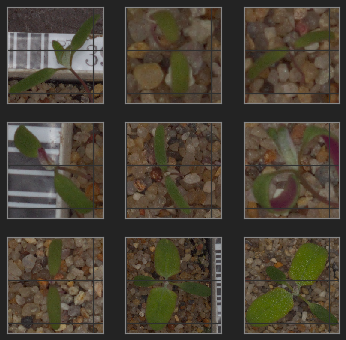

In [26]:
plot_for_class('Fat Hen')

## preprocess images

In [31]:
def create_mask_for_plant(image):
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    sensitivity = 35
    lower_hsv = np.array([60 - sensitivity, 100, 50])
    upper_hsv = np.array([60 + sensitivity, 255, 255])

    mask = cv2.inRange(image_hsv, lower_hsv, upper_hsv)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11,11))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    
    return mask

def segment_plant(image):
    mask = create_mask_for_plant(image)
    output = cv2.bitwise_and(image, image, mask = mask)
    return output

def sharpen_image(image):
    image_blurred = cv2.GaussianBlur(image, (0, 0), 3)
    image_sharp = cv2.addWeighted(image, 1.5, image_blurred, -0.5, 0)
    return image_sharp

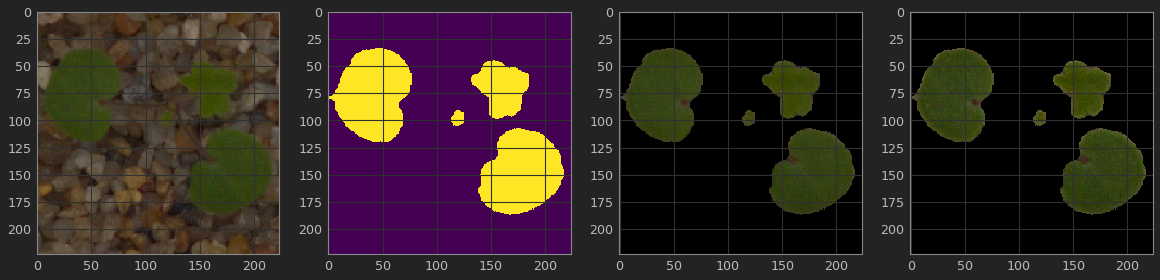

In [51]:
# Test image to see the changes
image = images_per_class["Small-flowered Cranesbill"][97].astype('uint8')

image_mask = create_mask_for_plant(image)
image_segmented = segment_plant(image)
image_sharpen = sharpen_image(image_segmented)

fig, axs = plt.subplots(1, 4, figsize=(20, 20))
axs[0].imshow(image.astype('uint8'))
axs[1].imshow(image_mask)
axs[2].imshow(image_segmented)
axs[3].imshow(image_sharpen)

In [52]:
def get_sharp_image(image):
    image = image.astype('uint8')
    image_mask = create_mask_for_plant(image)
    image_segmented = segment_plant(image)
    image_sharpen = sharpen_image(image_segmented)
    return image_sharpen

In [65]:
X_train = []
Y_train = np.zeros((4750, 12))
categories = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
i = 0
for class_label in tqdm(images_per_class):
    for image in images_per_class[class_label]:
        sharpened_image = get_sharp_image(image)
        X_train.append(sharpened_image)
        Y_train[i, categories.index(class_label)] = 1
        i+=1
        
X_train = np.asarray(X_train)

100%|██████████| 12/12 [01:05<00:00,  5.49s/it]


(<matplotlib.image.AxesImage at 0x7f85cc71dda0>, 'Shepherds Purse')

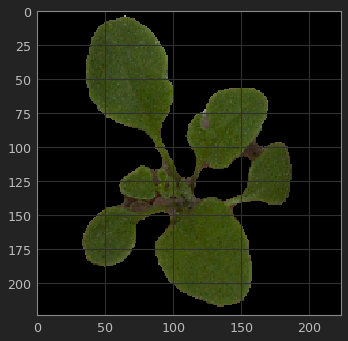

In [72]:
plt.imshow(X_train[0]), categories[np.argmax(Y_train[0])]

In [74]:
np.save('data/preprocessed/X_train.npy', X_train)
np.save('data/preprocessed/Y_train.npy', Y_train)

## load test images and save them as npy file

In [75]:
test = pd.read_csv('sample_submission.csv')
X_test = []
for fname in tqdm(test['file']):
    img = img_to_array(load_img('test/{}'.format(fname), target_size=(224, 224, 3)))
    X_test.append(get_sharpen_image(img))
    
X_test = np.asarray(X_test)
np.save('data/preprocessed/X_test.npy', X_test)

100%|██████████| 794/794 [00:20<00:00, 37.93it/s]


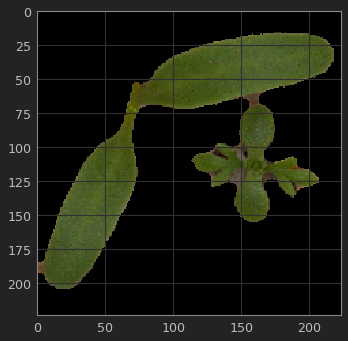

In [76]:
plt.imshow(X_test[12])